In [2]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

# Notebook for evaluating impact on precision by applying blank-out

In [3]:
import requests
import torch.nn.functional as F

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

In [41]:
img = Image.open("examples/input.png")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)
print()

Using cpu


Using cache found in /Users/francoisreynal/.cache/torch/hub/facebookresearch_deit_main


In [27]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

You should consider upgrading via the '/Users/francoisreynal/env_ea_map/bin/python3 -m pip install --upgrade pip' command.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 14, 14]         147,648
          Identity-2             [-1, 196, 192]               0
        PatchEmbed-3             [-1, 196, 192]               0
           Dropout-4             [-1, 197, 192]               0
          Identity-5             [-1, 197, 192]               0
         LayerNorm-6             [-1, 197, 192]             384
            Linear-7             [-1, 197, 576]         111,168
           Dropout-8          [-1, 3, 197, 197]               0
            Linear-9             [-1, 197, 192]          37,056
          Dropout-10             [-1, 197, 192]               0
        Attention-11             [-1, 197, 192]               0
         Identity-12             [-1, 197, 1

In [5]:
input_tensor  = preprocess_image("examples/input.png", transform)
scores = model(input_tensor)

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

def get_prediction(scores):
    '''Gets the index of max prob and the prob
    '''
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    # output the prediction
    return idx[0].item(), probs[0].item()

idx, prob = get_prediction(scores)

In [ ]:
def get_blank_out_mask(scores):
    '''
    '''

In [6]:
prob

0.2663801312446594

In [8]:
idx

243

### Naive approach 
Blacking out the initial image square by square, exactly the same way than the convolution filter will be. 
So the filter sees already black. 
Negative point. The blacked out image sqaure will have an influence on several convolution filters. 

In [6]:
import copy
import torch
import torch.nn.functional as F

def compute_blankout_importance_conv(model, input_tensor, initial_class, patch_size=14, discard_ratio=0.9):
    # Get the initial prediction
    initial_scores = model(input_tensor)
    initial_prob = F.softmax(initial_scores, dim=1)[0, initial_class].item()

    # Create a deep copy of the input tensor
    perturbed_tensor = copy.deepcopy(input_tensor)

    # Initialize the importance vector
    importance_vector = []

    # Iterate through each patch in the input tensor
    for i in range(0, input_tensor.size(2), patch_size):
        for j in range(0, input_tensor.size(3), patch_size):
            # Blank-out each patch in the input tensor
            perturbed_tensor = copy.deepcopy(input_tensor)
            perturbed_tensor[:, :, i:i+patch_size, j:j+patch_size] = 0  # Set all values to zero for each patch

            # Get the prediction after blanking-out the patch
            perturbed_scores = model(perturbed_tensor)
            perturbed_prob = F.softmax(perturbed_scores, dim=1)[0, initial_class].item()

            # Compute the impact on the probability
            impact = initial_prob - perturbed_prob
            importance_vector.append(impact)

    return importance_vector

# Usage example:
input_tensor = preprocess_image("examples/input.png", transform)
initial_class = get_prediction(scores)[0]
importance_vector_direct = compute_blankout_importance_conv(model, input_tensor, initial_class, patch_size=14, discard_ratio=DISCARD_RATIO)


256


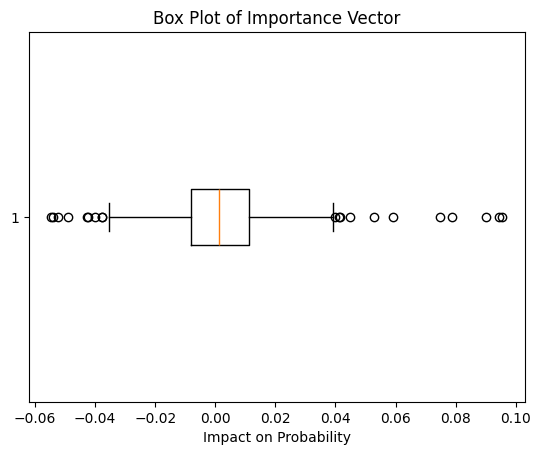

In [7]:
print(len(importance_vector_direct))

plt.boxplot(importance_vector_direct, vert=False)
plt.title('Box Plot of Importance Vector')
plt.xlabel('Impact on Probability')
plt.show()

### Better approach 

Apply the model first pos embedding layer and then black out one specific filter. 
Then, apply the rest of the model. 

In [41]:
# Print the entire model
print(model)

for name, module in model.named_children():
    print(name)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [64]:
import copy
import torch
import torch.nn.functional as F

model.eval()

def compute_blankout_importance_conv(model, input_tensor, initial_class, patch_size=16, discard_ratio=0.9):

    initial_scores = model(input_tensor)
    initial_prob = F.softmax(initial_scores, dim=1)[0, initial_class].item()

    # Get the output after the part of the model
    conv_output = model.patch_embed(input_tensor)
    print(conv_output.shape)

    importance_vector = []

    # Iterate through each patch in the convolutional output
    for i in range(conv_output.size(1)):

        perturbed_conv_output = conv_output.detach().clone()

        # Blank-out one patch in the convolutional output

        #print(perturbed_conv_output[:,i,:].shape)
        perturbed_conv_output[:, i, :] = 0  # Set all values to zero for one patch
        #print(conv_output.shape)

        # Pass the modified tensor through the rest of the model
        perturbed_conv_output = model.pos_drop(perturbed_conv_output)
        #print(perturbed_conv_output.shape)
        
        perturbed_conv_output = model.norm_pre(perturbed_conv_output)
        #print(perturbed_conv_output.shape)
        

        perturbed_conv_output = model.blocks(perturbed_conv_output)
        #print(perturbed_conv_output.shape)
        
        perturbed_conv_output = model.norm(perturbed_conv_output)
        #print(perturbed_conv_output.shape)

        ### HERE I ADD A GLOBAL POOLING LAYER
        # Global mean pooling
        perturbed_conv_output = perturbed_conv_output.mean(dim=1)

        perturbed_conv_output = model.fc_norm(perturbed_conv_output)
        #print(perturbed_conv_output.shape)

        # Fully connected layer
        perturbed_scores = model.head(perturbed_conv_output)
        #print(perturbed_scores.shape)

        perturbed_prob = F.softmax(perturbed_scores, dim=1)[0, initial_class].item()
        #print(perturbed_prob)

        impact = initial_prob - perturbed_prob
        importance_vector.append(impact)
        

    return importance_vector


input_tensor = preprocess_image("examples/input.png", transform)
initial_class = get_prediction(scores)[0]
importance_vector_conv = compute_blankout_importance_conv(model, input_tensor, initial_class, patch_size=16, discard_ratio=DISCARD_RATIO)


torch.Size([1, 196, 192])


196


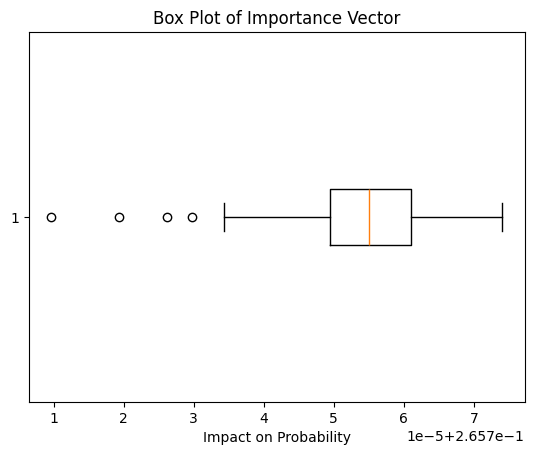

In [65]:

print(len(importance_vector_conv))

plt.boxplot(importance_vector_conv, vert=False)
plt.title('Box Plot of Importance Vector')
plt.xlabel('Impact on Probability')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


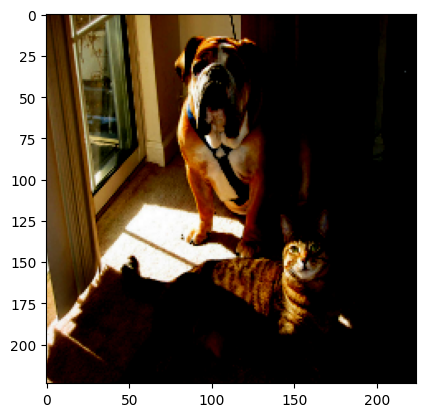

In [66]:
reshaped_image = np.squeeze(input_tensor)
reshaped_image = np.transpose(reshaped_image, (1, 2, 0))
plt.imshow(np.array(reshaped_image))

In [62]:
print(model(input_tensor).shape)


res = model.patch_embed(input_tensor)
res = model.pos_drop(res)
res = model.norm_pre(res)
res = model.blocks(res)
res = model.norm(res)
res = model.fc_norm(res)
res = model.head(res)
print(res.shape)

torch.Size([1, 1000])
torch.Size([1, 196, 1000])
